### A simple AR(2) example

The purpose of the simple example is to demonstrate the two estimation methodologies of interest (SMM and NPSMLE) on a toy data-generating process, in order to understand costs/benefits of each approach. The DGP is simply:

$$y_t = \beta_1 y_{t-1} + \beta_2 y_{t-2} + \epsilon_t$$

Let's start by importing the required packages as well as some utilities needed for the workbook. One of these is the autocorrelation function, which we'll be using to calculate the moments of the AR(2) process.

In [1]:
import time
import numpy as np

from scipy.stats import norm, skew
from numpy.random import default_rng
from matplotlib import pyplot as plt
from scipy.optimize import minimize
from workshopFunctions import autocorr, formatTableText
from statsmodels.iolib.table import SimpleTable

Now we need to import the data generating process and the two estimation classes. We also need to write a function that calculates the moments we're going to be using in the SMM estimation. The choice of moments is pretty simple in our case, as the Yule-Walker equations for an AR(2) tell us that the two autoregressive parameters are combinations of the first two lags of the autocorrelation function, therefore these two moments are sufficient to identify our model. I'm throwing in a few more moments (mean, variance, skewness) just to be safe and ensure an over-identified system.

In [2]:
def genMoments(data):
    """
    Generate the moments

    Parameters
    ----------
    data : numpy 1D array of floats
        Input data.

    Returns
    -------
    moments : numpy 1D array of floats
        Vector containing the moments of interest

    """
    data = data.flatten() # in case the data isn't already flat

    # Append moments below. This will need to change for each problem
    acf = autocorr(data)
    moments = np.array(np.mean(data))
    moments = np.append(moments,np.var(data))
    moments = np.append(moments,skew(data))
    moments = np.append(moments,acf[1])
    moments = np.append(moments,acf[2])
    
    return moments

Next, let's simulate the AR(2) process with a choice of parameters to generate our 'empirical' data. This will allow us to run a parameter recovery exercise. We're picking $\beta_1 = 0.7$ and $\beta_2 = -0.2$ as our ground truth values, and simulating for $T=500$ steps:

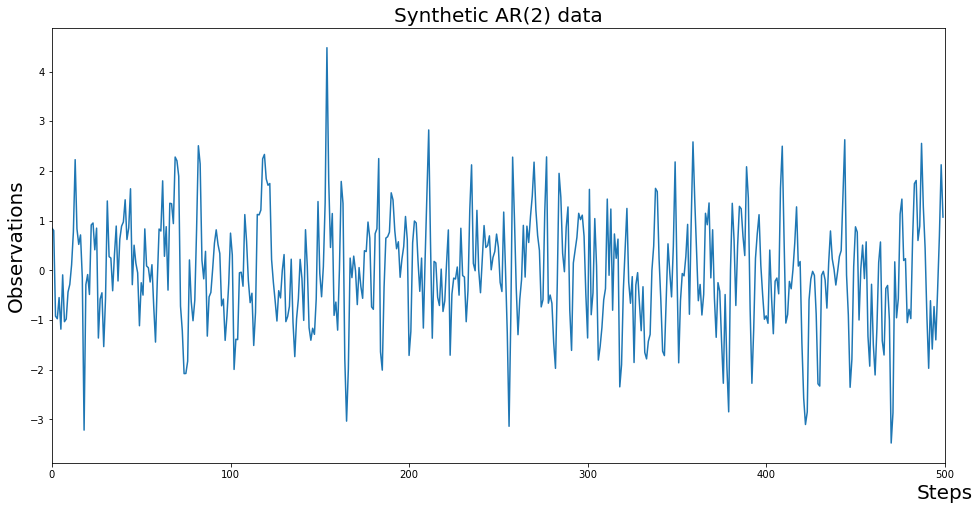

In [3]:
betaVec = np.asarray([0.7,-0.2])    # Pick some AR parameters
T = 500                             # pick simulation length
paramNames = ['Beta_1', 'Beta_2']

ARsim = AR(seed = 3)
ARsimData = ARsim.simulate(T+2,betaVec)
y = ARsimData[2:T+2]

# Plot the data
fig = plt.figure(figsize=(16,8))
fig.set_facecolor('white')
ax = plt.axes()
ax.plot(np.arange(T), y)
ax.set_xlim(0,T)
ax.set_xlabel(r'Steps', fontdict = {'fontsize': 20},position=(1, 0))
ax.set_ylabel(r'Observations', fontdict = {'fontsize': 20},position=(0, 0.5))
ax.set_title('Synthetic AR(2) data', fontdict = {'fontsize': 20});

Let's start by running the NPSMLE estimation. We're going to use 1000 MC replications for the non-parametric likelihood, and fix those shocks *ex-ante* for the whole estimation procedure.

In [4]:
# Pick parameters for the MC setting
N = 1000            # Number of MC replications
tolerance = 1e-3    # Tolerance on BFGS. Be generous. These are MC methods!

# Run the estimationm itself
print(' Running NPSMLE on synthetic AR(2) data')
t_start = time.time()

init = np.asarray([0,0])      # initialise a null model
epsRng = default_rng(seed = 400)
epsilon = norm.ppf(epsRng.random((N,1)))

ARnpsmle = npsmle(y,paramNames)
negLogLik = lambda a : -sum(ARnpsmle.logLike(ARsim.step,2,a,epsilon)/T)
smleEstimation = minimize(negLogLik, 
                          init,
                          method='BFGS', 
                          callback=ARnpsmle.callback,
                          options={'disp':True,
                                    'gtol':tolerance})
timeNpsmle = time.time() - t_start
print('Total time: {:10.4f} secs.'.format(timeNpsmle))
for name, value in zip(paramNames, smleEstimation.x):
    print('{:s} estimate: {:10.4f}'.format(name, value))

 Running NPSMLE on synthetic AR(2) data
 iteration      time        Beta_1       Beta_2     
────────────────────────────────────────────────────
     1        3.0884e+00   4.3138e-01   8.0235e-02  
     2        2.0039e+00   6.2336e-01  -2.2306e-01  
Optimization terminated successfully.
         Current function value: 12626.012248
         Iterations: 2
         Function evaluations: 15
         Gradient evaluations: 5
Total time:     5.0941 secs.
Beta_1 estimate:     0.6234
Beta_2 estimate:    -0.2231


The method is reasonably fast, and the estimates obtained seem to be close to the true values. 

Let's see the performance of SMM. We start with the 'naive' option, which is to set the weights matrix $W$ to the identity. We re-use the same parameters as the NPSMLE case, so $N=1000$ MC replications, a tolerance of 1e-3 on the BFGS gradient norm and a null model as the starting point:

In [5]:
print(' Running SMM on synthetic AR(2) data, W = identity\n')
t_start = time.time()
ARsmm1 = smm(y,genMoments, paramNames)     # 'default' SMM, identity matrix

smmObjective = lambda a : ARsmm1.dist(ARsim.simulate,a)
smmmEstimation1 = minimize(smmObjective, 
                          init,
                          method='BFGS', 
                          callback = ARsmm1.callback,
                          options={'disp':True,
                                    'gtol':tolerance})

timeSmm1 = time.time() - t_start
print('Total time: {:10.4f} secs.'.format(timeSmm1))
for name, value in zip(paramNames, smmmEstimation1.x):
    print('{:s} estimate: {:10.4f}'.format(name, value))

 Running SMM on synthetic AR(2) data, W = identity

 iteration      time        Beta_1       Beta_2     
────────────────────────────────────────────────────
     1        3.5742e+01   1.4955e-02   9.7185e-02  
     2        1.8482e+01   1.3071e-01   9.9958e-02  
     3        9.5504e+00   2.2814e-01   7.3502e-02  
     4        1.0871e+01   2.6457e-01   2.7693e-02  
     5        9.8710e+00   3.1832e-01   2.4765e-03  
     6        1.0611e+01   3.5187e-01  -1.8005e-02  
     7        9.8154e+00   3.5834e-01  -2.4264e-02  
     8        9.3067e+00   3.6068e-01  -2.5539e-02  
     9        9.4413e+00   3.6065e-01  -2.5539e-02  
Optimization terminated successfully.
         Current function value: 3.176762
         Iterations: 9
         Function evaluations: 39
         Gradient evaluations: 13
Total time:   123.6915 secs.
Beta_1 estimate:     0.3606
Beta_2 estimate:    -0.0255


This doesn't look that great, but that's not a surprise: we know that estimates will be sensitive to the specification of $W$. Using $W=I$ implies:
1. The the moments are uncorrelated
2. That they are equally precisely estimated


This is extremely unlikely to hold here, so let's try and improve this by using the two-step estimator for $W$, based on the variance-covariance of the simulated moments at the parameter estimates obtained using $W=I$:

In [6]:
# Let's generate an ensemble of simulated data and associated moments:
momentEnsemble = np.zeros([len(ARsmm1.empMoments),N])
for rep in range(N):
    simData = ARsim.simulate(T,smmmEstimation1.x,rep)
    momentEnsemble[:,rep] = genMoments(simData)

# The new W is the inverse of the variance-covariance of the moments
momentCovariance = np.cov(momentEnsemble)
newW = np.linalg.inv(momentCovariance)

Let's run a second SMM estimation with this new $W$ matrix, and see if things improve:

In [7]:
print(' Running SMM on synthetic AR(2) data, W = two-stage\n')
t_start = time.time()
ARsmm2 = smm(y,genMoments, paramNames, W = newW) # User provided W.

smmObjective = lambda a : ARsmm2.dist(ARsim.simulate,a)
smmmEstimation2 = minimize(smmObjective, 
                          init,
                          method='BFGS', 
                          callback = ARsmm2.callback,
                          options={'disp':True,
                                    'gtol':tolerance})

timeSmm2 = time.time() - t_start
print('Total time: {:10.4f} secs.'.format(timeSmm2))
for name, value in zip(paramNames, smmmEstimation2.x):
    print('{:s} estimate: {:10.4f}'.format(name, value))

 Running SMM on synthetic AR(2) data, W = two-stage

 iteration      time        Beta_1       Beta_2     
────────────────────────────────────────────────────
     1        3.8890e+01   3.6395e-02   3.9591e-02  
     2        1.0448e+01   1.1868e-01   4.6631e-02  
     3        9.6792e+00   2.5993e-01   2.5416e-02  
     4        1.0377e+01   2.9551e-01  -2.4472e-02  
     5        9.4421e+00   3.7890e-01  -5.6889e-02  
     6        8.9958e+00   4.5581e-01  -9.8554e-02  
     7        9.9376e+00   4.8680e-01  -1.2656e-01  
     8        9.4118e+00   5.2437e-01  -1.5232e-01  
     9        9.3692e+00   5.4097e-01  -1.6478e-01  
    10        9.3038e+00   5.4610e-01  -1.6856e-01  
    11        9.3190e+00   5.4663e-01  -1.6899e-01  
    12        9.3416e+00   5.4670e-01  -1.6903e-01  
    13        9.3212e+00   5.4668e-01  -1.6901e-01  
Optimization terminated successfully.
         Current function value: 429.830446
         Iterations: 13
         Function evaluations: 48
         Gra

The estimates have improved markedly, and are now much closer to those obtained via the NPSMLE method.

As a final demonstration, we'll run the SMM method with an automatic method of generating a good $W$ matrix. In theory, an optimal estimate of $W$ can be obtained using the Newey-West HAC estimator. The implementation I provide shows that in practice, you can also get good performance using the variance-covariance matrix obtained via a block bootstrap resampling of the empirical data itself, see for example Tubbenhauer *et al.* (2021):

In [8]:
print(' Running SMM on synthetic AR(2) data, W = bootstrap\n')
t_start = time.time()
ARsmm3 = smm(y,genMoments, paramNames, bootstrap = True) # Bootstrapped W

smmObjective = lambda a : ARsmm3.dist(ARsim.simulate,a)
smmmEstimation3 = minimize(smmObjective, 
                          init,
                          method='BFGS', 
                          callback = ARsmm3.callback,                         
                          options={'disp':True,
                                    'gtol':tolerance})

timeSmm3 = time.time() - t_start
print('Total time: {:10.4f} secs.'.format(timeSmm3))
for name, value in zip(paramNames, smmmEstimation3.x):
    print('{:s} estimate: {:10.4f}'.format(name, value))

 Running SMM on synthetic AR(2) data, W = bootstrap

 iteration      time        Beta_1       Beta_2     
────────────────────────────────────────────────────
     1        3.8437e+01   5.2013e-02   3.9270e-02  
     2        9.4657e+00   1.4806e-01   4.4904e-02  
     3        9.4683e+00   2.6018e-01   1.2284e-02  
     4        9.3312e+00   3.1974e-01  -4.2593e-02  
     5        8.6258e+00   4.6597e-01  -9.2532e-02  
     6        8.5990e+00   4.3561e-01  -9.3938e-02  
     7        9.9640e+00   4.7810e-01  -1.2009e-01  
     8        9.6735e+00   5.7485e-01  -1.8206e-01  
     9        9.7588e+00   5.9591e-01  -2.0222e-01  
    10        9.6499e+00   6.3048e-01  -2.2867e-01  
    11        8.9559e+00   6.4089e-01  -2.3716e-01  
    12        9.0460e+00   6.4375e-01  -2.3938e-01  
    13        9.2647e+00   6.4380e-01  -2.3945e-01  
    14        9.2710e+00   6.4382e-01  -2.3946e-01  
         Current function value: 351.947445
         Iterations: 14
         Function evaluations: 

Let's gather all the estimates and timers into a single table to compare the performance:

In [9]:
# Gather parameter values 
parameterValues = np.concatenate(
                            (betaVec[None,:],
                             smleEstimation.x[None,:],
                             smmmEstimation1.x[None,:],
                             smmmEstimation2.x[None,:],
                             smmmEstimation3.x[None,:]),
                                  axis=0)
# Gather compute times 
times = np.asarray([0,timeNpsmle,timeSmm1,timeSmm1+timeSmm2,timeSmm3])

# Print table
tableValues = np.concatenate((parameterValues,times[:,None]),axis = 1)
table = SimpleTable(
        formatTableText(tableValues,'{:8.3f}'),
        stubs=['True','NPSMLE', 'SMM W = I', 'SMM 2-step W', 'SMM btstrp W'],
        headers=paramNames + ['Time'],
        title='Estimation performance',
    )

print(table)
print('\n')

         Estimation performance        
              Beta_1   Beta_2    Time  
---------------------------------------
True            0.700   -0.200    0.000
NPSMLE          0.623   -0.223    5.094
SMM W = I       0.361   -0.026  123.692
SMM 2-step W    0.547   -0.169  277.527
SMM btstrp W    0.644   -0.239  380.309
---------------------------------------




What we see is that the estimates obtained by both methods are essentially similar, and not too far from the truth. Note, we can't expect to exactly hit the true values, because of sampling error. We only have a sample of 500 observations, so it is likely that these estimates are as good as it gets. 

The table also establishes the importance of correctly specifying the $W$ matrix for SMM, as well as the time cost of the two-step estimation. The bootstrapped $W$ has better performance than the two-step estimator, and is much faster.

Finally, let's compare the $W$ matrix obtained by the two-step estimator and the bootstrap. As you can see, the scale of the diagonal is very similar, and most of the off-diagonal elements are also very comparable in magnitude. 

In [10]:
# Print the two-step matrix
table = SimpleTable(
        formatTableText(newW,'{:5.3f}'),
        title='Two-step W matrix',
    )
print(table)
print('\n')

# Print the bootstrap matrix
table = SimpleTable(
        formatTableText(ARsmm3.W,'{:5.3f}'),
        title='Bootstrapped W matrix',
    )
print(table)

            Two-step W matrix            
226.395    3.048  3.154   10.839  -18.897
  3.048  186.470 -0.920 -188.262   15.906
  3.154   -0.920 74.864   -2.996   -1.292
 10.839 -188.262 -2.996 1108.625 -462.215
-18.897   15.906 -1.292 -462.215  614.514
-----------------------------------------


          Bootstrapped W matrix          
235.122    8.762 -6.522   15.679   -8.003
  8.762  132.849 -5.099 -118.257   22.232
 -6.522   -5.099 47.816   27.998   -2.462
 15.679 -118.257 27.998 1291.619 -615.719
 -8.003   22.232 -2.462 -615.719  734.562
-----------------------------------------
